# HSE 2023: Введение в машинное обучение БИ 22/23

## Домашнее задание № 3


# Внимание!

* Некоторые задания требуют значительного времени для выполнения (особенно часть с лемматизацией), поэтому **лучше приступить к выполнению домашнего задания как можно раньше** 

* Решения обязательно должны содержать комментарии, все полученные результаты должны сопровождаться выводами (для этого удобно использовать ячейки markdown)

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## ЧАСТЬ 1: Логистическая регрессия

Будем решать задачу бинарной классификации с помошью логистической регрессии.
Для борьбы с переобучением будем использовать регуляризацию - комбинацию $L_1$ и $L_2$ (Elastic Net loss).

Для каждого объекта обучающей выборки, заданного своим признаковым описанием $x_i\in\mathbb{R}^{K}$ (вектор из $k$ признаков), указан его класс $y_i$ (одно из двух значений). Параметрами модели являются смещение $w_0\in\mathbb{R}$ и веса $w\in\mathbb{R}^K$.

Таким образом, оптимизируемый функционал (Elastic Net loss) можно записать в виде:

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 балла] Запишите формулу градиента Elastic Net loss (с выводом этой формулы, для форматирования лучше использовать Latex)

Для нахождения градиента сначала найдем частные производные функции $L(w, w_0)$ по $w_0$ и $w_j$, где $j\in{1, 2, ..., K}$:

$$\frac{\partial L}{\partial w_0} = -\frac{1}{N} \sum_{i=1}^N \frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))}$$

$$\frac{\partial L}{\partial w_k} = -\frac{1}{N} \sum_{i=1}^N \left(x_{ik}\frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} + \gamma \text{sign}(w_k)\right)$$


Таким образом, градиент функции Elastic Net loss имеет вид:

$$\nabla_w L = \begin{pmatrix} \frac{\partial L}{\partial w_0} \\ \frac{\partial L}{\partial w_1} \\ \vdots \\ \frac{\partial L}{\partial w_K} \end{pmatrix} = -\frac{1}{N} \sum_{i=1}^N \begin{pmatrix} \frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} \\ x_{i1}\frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} + \gamma \text{sign}(w_1) + 2\beta w_1 \\ \vdots \\ x_{iK}\frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} + \gamma \text{sign}(w_K) + 2\beta w_K \end{pmatrix}$$

Или если регуляризация для $w_0$ не требуется

$$\nabla_w L = \begin{pmatrix} \frac{\partial L}{\partial w_0} \\ \frac{\partial L}{\partial w_1} \\ \vdots \\ \frac{\partial L}{\partial w_K} \end{pmatrix} = -\frac{1}{N} \sum_{i=1}^N \begin{pmatrix} \frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} \\ x_{i1}\frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} + \gamma \text{sign}(w_1) \\ \vdots \\ x_{iK}\frac{y_i}{1+\exp(y_i(w^\top x_i+w_0))} + \gamma \text{sign}(w_K) \end{pmatrix}$$



#### 2. [0.25 балла] Реализуйте функцию вычисления Elastic Net loss

In [2]:
def loss(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N, K = X.shape
    loss_value = 0.
    for i in range(N):
        z = y[i] * (np.dot(w, X[i]) + w0)
        loss_value += np.log(1 + np.exp(-z))
    loss_value /= N
    loss_value += gamma * np.linalg.norm(w, ord=1) + beta * np.linalg.norm(w, ord=2)**2
    return loss_value

#### 3. [0.25 балла] Реализуйте функцию вычисления градиента

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    N, K = X.shape
    grad_w = np.zeros(K)
    grad_w0 = 0.
    for i in range(N):
        xi = X[i]
        yi = y[i]
        pred = sigmoid(yi * (np.dot(w, xi) + w0))
        grad_w += -yi * xi * (1 - pred) / N
        grad_w0 += -yi * (1 - pred) / N
    grad_w += gamma * np.sign(w) + 2 * beta * w
    return grad_w, grad_w0

#### Проверьте корректность реализованных функций

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)

print(grad_w)
print(grad_w0)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690745


In [6]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 балл]  Реализуйте алгоритм градиентного спуска, поддержав различные критерии остановки: ограничение на количество итераций (max_iter) и ограничение на размер шага ([tolerance](https://nl.mathworks.com/help/optim/ug/tolerances-and-stopping-criteria.html)).

Проверьте корректность реализации, визуализировав полученную разделяющую поверхность ([plot_decision_boundary](https://towardsdatascience.com/logistic-regression-from-scratch-in-python-ec66603592e2)).

Ниже представлен шаблон класса, соответствующий стандартному API моделей sklearn.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.losses = []
        
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1., beta=1.) -> float:
        N, K = X.shape
        loss_value = 0.
        for i in range(N):
            z = y[i] * (np.dot(w, X[i]) + w0)
            loss_value += np.log(1 + np.exp(-z))
        loss_value /= N
        loss_value += gamma * np.linalg.norm(w, ord=1) + beta * np.linalg.norm(w, ord=2)**2
        return loss_value
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def calc_grad(self, X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
        N, K = X.shape
        grad_w = np.zeros(K)
        grad_w0 = 0.
        for i in range(N):
            xi = X[i]
            yi = y[i]
            pred = self.sigmoid(yi * (np.dot(w, xi) + w0))
            grad_w += -yi * xi * (1 - pred) / N
            grad_w0 += -yi * (1 - pred) / N
        grad_w += gamma * np.sign(w) + 2 * beta * w
        return grad_w, grad_w0    
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape
        self.w = np.random.randn(K)
        self.w0 = 0.
        for it in range(self.max_iter):
            # Calculate gradients
            grad_w, grad_w0 = self.calc_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            
            # Update weights
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0
            
            # Calculate loss
            loss = self.calc_loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.losses.append(loss)
            
            # Check if tolerance condition is met
            if it > 0 and abs(self.losses[-1] - self.losses[-2]) < self.tolerance:
                break
                
        return self
    
    def predict(self, X):
        # return vector of predicted labels for each object from X
        return np.sign(np.dot(X, self.w) + self.w0)
        
    def predict_proba(self, X):
        return np.array([self.sigmoid(np.dot(X, self.w) + self.w0),\
                         1 - self.sigmoid(np.dot(X, self.w) + self.w0)])

In [9]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [10]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

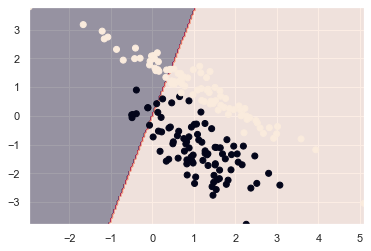

In [11]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

**Воспользуемся GridSearchCV для подбора гиперпараметров модели:**

In [12]:
param_grid = {'beta': [0.1, 1, 10, 100],
              'gamma': [0.1, 1, 10, 100]}
              
grid_search = GridSearchCV(Logit(), param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Logit(),
             param_grid={'beta': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100]})

In [13]:
grid_search.best_params_

{'beta': 10, 'gamma': 100}

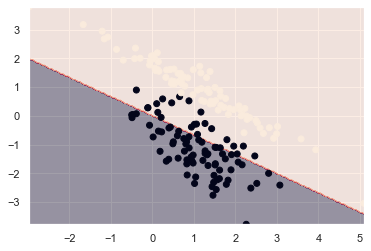

In [14]:
model = Logit(beta = 10, gamma = 100)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

**Результат улучшился, попробуем еще чуть-чуть улучшить качество модели поменяв гиперпараметры.**

In [15]:
param_grid = {'beta': [8, 9, 10, 11, 12],
              'gamma': [98, 99, 100, 101, 102]}
              
grid_search = GridSearchCV(Logit(), param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Logit(),
             param_grid={'beta': [8, 9, 10, 11, 12],
                         'gamma': [98, 99, 100, 101, 102]})

In [16]:
grid_search.best_params_

{'beta': 8, 'gamma': 98}

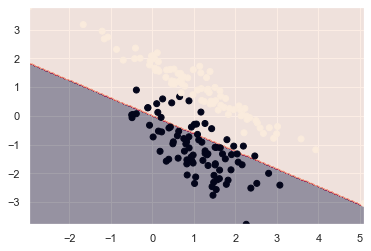

In [17]:
model = Logit(beta = 8, gamma = 98)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

С помощью подбора более оптимальных коэффициентов регуляризации, получилось улучшить качество модели и получить не самый плохой классификатор **:D**

Два графика рядом для сравнения:

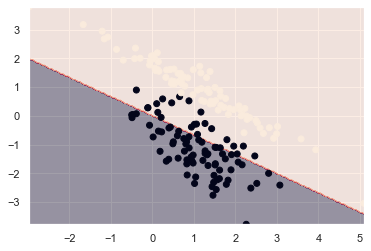

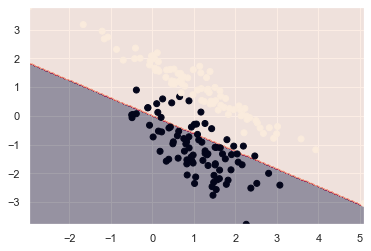

In [18]:
model1 = Logit(beta = 10, gamma = 100)
y[y == 0] = -1
model1.fit(X, y)
plot_decision_boundary(model1, X, y)

model2 = Logit(beta = 8, gamma = 98)
y[y == 0] = -1
model2.fit(X, y)
plot_decision_boundary(model2, X, y)

#### 5. [0.25 балла] Постройте график зависимости значения функции потерь от номера итерации градиентного спуска.

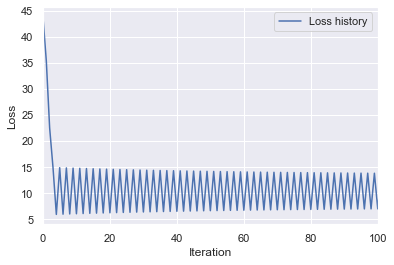

In [19]:
model = Logit(beta = 8, gamma = 98)
model.fit(X, y)

plt.plot(model.losses, label='Loss history')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xlim([0, 100])
plt.legend()
plt.show()

Как видно из графика, алгоритм сначала очень быстро сходится, а потом получается такая "пружинка", которая колеблется вокруг значения Loss ~10 на графике, но постепенно пусть и ооочень медленно продолжает сходиться.

## Часть 2: Support Vector Machines

#### 6. [2 балла] Обучите [SVM](https://scikit-learn.org/stable/modules/svm.html) классификатор на том же наборе данных.

Поисследуйте влияние гиперпараметров на качество обученной модели:
+ Попробуйте несколько ядер: линейное, полиномиальное, RBF (и другие, если хотите). У некоторых ядер есть гиперметры: не забудьте поэкспериментировать с ними!
+ Попробуйте разные коэффициенты регуляризации

В качестве метрик качества будем использовать accuracy, roc_auc и f1 score. 
Постройте графики зависимости метрик качества от гиперпараметров.

Какие выводы можно сделать на основе проведенных экспериментов? Насколько чувствительны ядра к гиперпараметрам? Какое ядро склонно приводить к переобучению? Насколько сильно на качество моделей влияет регуляризация?

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

In [21]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
C_range = np.logspace(-3, 3, 7)
kernel_list = ['linear', 'poly', 'rbf']

In [24]:
accuracy_results = {'linear': [], 'poly': [], 'rbf': []}
roc_auc_results = {'linear': [], 'poly': [], 'rbf': []}
f1_score_results = {'linear': [], 'poly': [], 'rbf': []}

В первом цикле мы идем по каждому из наиболее популярных ядер метода опорных векторов, а именно линейному, полиномиальному и радиально-базисному. 

Во втором цикле для каждого из ядер мы перебираем ключевой гиперпараметр C, который является коэффициентом регуляризации и контролирует соотношение между жесткостью decision boundary и обобщением модели. Если например данные линейно не различимы, то в модификации метода SVM нельзя устанавливать высокое значение регуляризации C, потому что при установке в таком случае жесткой границы принятия решений, модель с высокой долей вероятности переобучится.

Для полиномиального ядра мы дополнительно используем гиперпараметр degree, который задает степень полинома, лежащего в основе ядра. При работе SVM с ядром Poly, разделяющая гиперплоскость будет иметь вид полинома заданной степени. По умолчанию степень полинома равна 3, мы дополнительно протестриуем ее со значении равным 2. Использовать высокие значения данного гиперпараметра в нашем случае не имеет особого смысла, тк обычно высокий degree используют при работе с данными большой размерности для моделирования нелинейной зависимости между признаками.

In [25]:
for kernel in kernel_list:
    for C in C_range:
        if kernel == 'poly':
            for degree in [2, 3]:
                accuracy_results[kernel].append([])
                roc_auc_results[kernel].append([])
                f1_score_results[kernel].append([])
                svm = SVC(kernel=kernel, degree=degree, C=C, random_state=42)
                svm.fit(X_train, y_train)
                y_pred = svm.predict(X_test)
                accuracy_results[kernel][-1].append(accuracy_score(y_test, y_pred))
                roc_auc_results[kernel][-1].append(roc_auc_score(y_test, y_pred))
                f1_score_results[kernel][-1].append(f1_score(y_test, y_pred))
        else:
            accuracy_results[kernel].append([])
            roc_auc_results[kernel].append([])
            f1_score_results[kernel].append([])
            svm = SVC(kernel=kernel, C=C, random_state=42)
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_test)
            accuracy_results[kernel][-1].append(accuracy_score(y_test, y_pred))
            roc_auc_results[kernel][-1].append(roc_auc_score(y_test, y_pred))
            f1_score_results[kernel][-1].append(f1_score(y_test, y_pred))

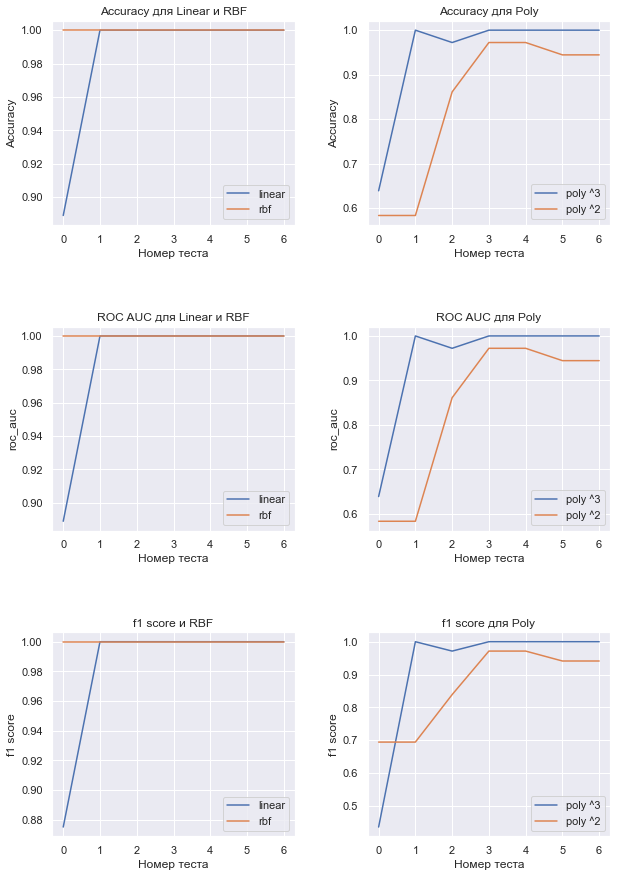

In [26]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

x_values = list(range(len(accuracy_results['linear'])))
ax1.plot(x_values, accuracy_results['linear'], label='linear')
ax1.plot(x_values, accuracy_results['rbf'], label='rbf')
ax1.set_xlabel('Номер теста')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy для Linear и RBF')
ax1.legend()

ax2.plot(x_values, accuracy_results['poly'][1::2], label='poly ^3')
ax2.plot(x_values, accuracy_results['poly'][0::2], label='poly ^2')
ax2.set_xlabel('Номер теста')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy для Poly')
ax2.legend()


x_values = list(range(len(roc_auc_results['linear'])))
ax3.plot(x_values, roc_auc_results['linear'], label='linear')
ax3.plot(x_values, roc_auc_results['rbf'], label='rbf')
ax3.set_xlabel('Номер теста')
ax3.set_ylabel('roc_auc')
ax3.set_title('ROC AUC для Linear и RBF')
ax3.legend()

ax4.plot(x_values, roc_auc_results['poly'][1::2], label='poly ^3')
ax4.plot(x_values, roc_auc_results['poly'][0::2], label='poly ^2')
ax4.set_xlabel('Номер теста')
ax4.set_ylabel('roc_auc')
ax4.set_title('ROC AUC для Poly')
ax4.legend()


x_values = list(range(len(f1_score_results['linear'])))
ax5.plot(x_values, f1_score_results['linear'], label='linear')
ax5.plot(x_values, f1_score_results['rbf'], label='rbf')
ax5.set_xlabel('Номер теста')
ax5.set_ylabel('f1 score')
ax5.set_title('f1 score и RBF')
ax5.legend()

ax6.plot(x_values, f1_score_results['poly'][1::2], label='poly ^3')
ax6.plot(x_values, f1_score_results['poly'][0::2], label='poly ^2')
ax6.set_xlabel('Номер теста')
ax6.set_ylabel('f1 score')
ax6.set_title('f1 score для Poly')
ax6.legend()

plt.show()

Можем заметить, что значения метрики ROC AUC для всех 3 версий модели SVC соответсвутют значениям метрики Accuracy. Это связано с тем, что данные двух наших классов линейно разделимы, а также хорошо сбалансированы. 

Значения метрики f1 score номинально отличаются от метрик ROC AUC и Accuracy, но в целом показывают ту же тенденцию что и значения двух других метрик.

При тестировании разных версий модели на наших данных тяжело сказать, насколько чувствительны ядра к изменениям гиперпараметров и какое ядро больше склонно приводить к переобучению, тк наши данные слишком "хорошие", и даже при совсем разных значениях регуляризации модель показывает очень хорошие результаты, однако можем заметить, что SVC с полиномиальным ядром и полиномом второй степени в основе недообучается, что говорит о том, что данная модель не может в должной степени оценить зависимость данных объекта от его метки.

Также можем заметить, что изменение степени регуляризации или вообще не влияет, или почти не влияет на качество работы этих версий SVC на наших данных с метриками accuracy, roc auc, f1 score.

Визуализация работы SVC с разными типа ядра на наших данных:

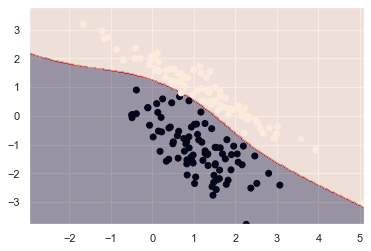

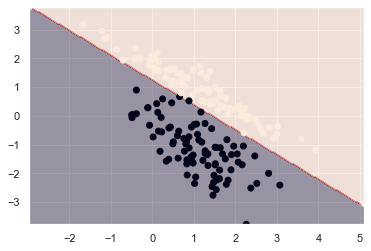

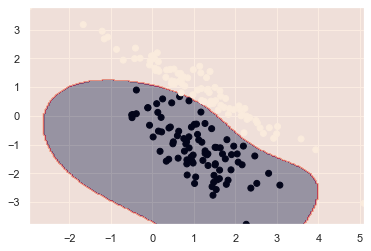

In [27]:
svm1 = SVC(kernel='poly', C=100, random_state=42, degree = 3)
svm2 = SVC(kernel='linear', C=100, random_state=42)
svm3 = SVC(kernel='rbf', C=100, random_state=42)

svm1.fit(X_train, y_train)
svm2.fit(X_train, y_train)
svm3.fit(X_train, y_train)

plot_decision_boundary(svm1, X, y)
plot_decision_boundary(svm2, X, y)
plot_decision_boundary(svm3, X, y)

## Часть 3: Natural Language Processing

In [28]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#### 7. [1.75 балла] Подготовка данных

Подготовим набор данных, который будем использовать для бинарной и многоклассовой классификации.

0. Выберите **шесть** любимых писателей-прозаиков (укажите, кого вы выбрали) и скачайте  <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">данные</a> из раздела **проза**
1. Подготовьте собственный датасет из выбранных авторов: 
    * разделите каждый текст на предложения так, чтобы представить данные в виде *предложение* and *автор* (каждая строка обучающего набора данных содержит ровно одно предложение и одного автора текста, откуда было взято это предложение);
    * удалите короткие предложения (считаем, что предложение короткое, если в нем меньше 15 символов);
    * зафиксируйте random state и случайно сформируйте выборку из предложений размера "5k : 15k : 8k : 11k : 20k : 3k" в разбивке по авторам соответственно;
    
    Пример полученных данных:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Предварительная обработка данных: 
    * токенизируйте предложения, удалите все стоп-слова (nltk.corpus.stopwords), знаки пунктуации (string.punctuation) и числа;
    * преобразуйте все символы в нижний регистр и примените стемминг или лемматизацию (на свое усмотрение)
    * постройте векторные представления предложений с помощью **bag of words** и **tf-idf** (используйте средства sklearn)
    * обратите внимание на разницу между полученными векторными представлениями: чем отличаются векторы, полученные с помощью **bag of words** и **tf-idf**?

### Чехов 3.2к

In [29]:
path = r"C:\Users\Egor\Desktop\jupyter\hse_ml_course\texts_for_NLP\Чехов"

Chekhov = []

for filename in os.listdir(path):
    if filename.endswith(".txt"): 
        with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
            sentences = file.read().split(".")
            for sentence in sentences:
                if len(sentence.split()) > 15:
                    Chekhov.append(sentence.strip())

print(len(Chekhov))
data = {"Предложение": Chekhov, "Автор": "Чехов"}
df1 = pd.DataFrame(data)
df1.head()

3219


,Предложение,Автор
0,Антон Чехов\nАГАФЬЯ\nВ бытность мою в С—м уезд...,Чехов
1,Эти огороды были моим излюбленным местом для т...,Чехов
2,"Собственно говоря, меня не так занимала рыбная...",Чехов
3,Слыл он за человека рассудительного и толковог...,Чехов
4,"Жил он, как и все на деревне, в собственной из...",Чехов


### Горький 8.7к

In [30]:
path = r"C:\Users\Egor\Desktop\jupyter\hse_ml_course\texts_for_NLP\Горький"

Gorky = []

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
            sentences = file.read().split(".")
            for sentence in sentences:
                if len(sentence.split()) > 15:
                    Gorky.append(sentence.strip())

print(len(Gorky))
data = {"Предложение": Gorky, "Автор": "Горький"}
df2 = pd.DataFrame(data)
df2.head()

8678


,Предложение,Автор
0,Максим Горький\n В людях\n \n \n ДЕТ...,Горький
1,"Мать, полуголая, в красной юбке, стоит на коле...",Горький
2,"Меня держит за руку бабушка, — круглая, больше...",Горький
3,"Я никогда еще не видал, чтобы большие плакали,...",Горький
4,"Она ответила:\n — С верху, из Нижнего, да н...",Горький


### Брюсов 3.7k

In [31]:
path = r"C:\Users\Egor\Desktop\jupyter\hse_ml_course\texts_for_NLP\Брюсов"

Bryusov = []

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
            sentences = file.read().split(".")
            for sentence in sentences:
                if len(sentence.split()) > 15:
                    Bryusov.append(sentence.strip())

print(len(Bryusov))
data = {"Предложение": Bryusov, "Автор": "Брюсов"}
df3 = pd.DataFrame(data)
df3.head()

3684


,Предложение,Автор
0,I\n\n Наш корабль уже был в виду берегов Ита...,Брюсов
1,"Скромному провинциалу, сыну удаленной Аквитани...",Брюсов
2,"В тот час я не думал о жестоких унижениях, нан...",Брюсов
3,"Я и мой новый друг, Публий Ремигий, с которым ...",Брюсов
4,"Впрочем, он делал это охотно, так как ему, про...",Брюсов


### Достоевский 22.2к

In [33]:
path = r"C:\Users\Egor\Desktop\jupyter\hse_ml_course\texts_for_NLP\Достоевский"

Dostoevsky = []

for filename in os.listdir(path):
    if filename.endswith(".txt"): 
        with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
            sentences = file.read().split(".")
            for sentence in sentences:
                if len(sentence.split()) > 15:
                    Dostoevsky.append(sentence.strip())

print(len(Dostoevsky))
data = {"Предложение": Dostoevsky, "Автор": "Достоевский"}
df4 = pd.DataFrame(data)
df4.head()

22241


,Предложение,Автор
0,Посвящается Анне Григорьевне Достоевской\n ...,Достоевский
1,А именно: хотя я и называю Алексея Федоровича ...,Достоевский
2,"Ну а коль прочтут роман и не увидят, не соглас...",Достоевский
3,"Но странность и чудачество скорее вредят, чем ...",Достоевский
4,Не так ли?\n Вот если вы не согласитесь с эт...,Достоевский


### Толстой 16.9к

In [34]:
path = r"C:\Users\Egor\Desktop\jupyter\hse_ml_course\texts_for_NLP\Толстой"

Tolstoy = []

for filename in os.listdir(path):
    if filename.endswith(".txt"): 
        with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
            sentences = file.read().split(".")
            for sentence in sentences:
                if len(sentence.split()) > 15:
                    Tolstoy.append(sentence.strip())

print(len(Tolstoy))
data = {"Предложение": Tolstoy, "Автор": "Толстой"}
df5 = pd.DataFrame(data)
df5.head()

16934


,Предложение,Автор
0,"Non, je vous pr&#233;viens que si vous ne me d...",Толстой
1,Так говорила в июле 1805 года известная Анна П...,Толстой
2,"Анна Павловна кашляла несколько дней, у нее бы...",Толстой
3,"В записочках, разосланных утром с красным лаке...",Толстой
4,"— Dieu, quelle virulente sortie![4] — отвечал,...",Толстой


### Гоголь 8.1k

In [35]:
path = r"C:\Users\Egor\Desktop\jupyter\hse_ml_course\texts_for_NLP\Гоголь"

Gogol = []

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r", encoding="utf-8") as file:
            sentences = file.read().split(".")
            for sentence in sentences:
                if len(sentence.split()) > 15:
                    Gogol.append(sentence.strip())

print(len(Gogol))
data = {"Предложение": Gogol, "Автор": "Гоголь"}
df6 = pd.DataFrame(data)
df6.head()

8120


,Предложение,Автор
0,Николай Васильевич Гоголь\n Вечера на хут...,Гоголь
1,"Слушало, слышало вещее мое все эти речи еще за...",Гоголь
2,"Еще бы ничего, пусть уже высшее лакейство, нет...",Гоголь
3,» Я вам скажу… Да что говорить! Мне легче два ...,Гоголь
4,"У нас, мои любезные читатели, не во гнев будь ...",Гоголь


### Объединение датафреймов авторов

In [36]:
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
print(df.head())

                                         Предложение  Автор
0  Антон Чехов\nАГАФЬЯ\nВ бытность мою в С—м уезд...  Чехов
1  Эти огороды были моим излюбленным местом для т...  Чехов
2  Собственно говоря, меня не так занимала рыбная...  Чехов
3  Слыл он за человека рассудительного и толковог...  Чехов
4  Жил он, как и все на деревне, в собственной из...  Чехов


In [37]:
class_counts = df['Автор'].value_counts()
print(class_counts)

Достоевский    22241
Толстой        16934
Горький         8678
Гоголь          8120
Брюсов          3684
Чехов           3219
Name: Автор, dtype: int64


***Датафрейм получен >^,^<***

* **токенизируйте предложения, удалите все стоп-слова (nltk.corpus.stopwords), знаки пунктуации (string.punctuation) и числа**

In [39]:
sentence = df.iloc[5]["Предложение"]

tokens = word_tokenize(sentence, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]

russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]

* **преобразуйте все символы в нижний регистр и примените стемминг или лемматизацию (на свое усмотрение)**

In [40]:
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

### Пример реализации предобработки текста на одном предложении

In [41]:
print(f"Исходный текст: {sentence}\n")
print(f"Токены: {tokens}]\n")
print(f"Токены без пунктуации: {tokens_without_punctuation}\n")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}\n")
print(f"Токены после стемминга: {stemmed_tokens}\n")

Исходный текст: Старуха мать его побиралась под окнами, и сам он жил, как птица небесная: утром не знал, что будет есть в полдень

Токены: ['Старуха', 'мать', 'его', 'побиралась', 'под', 'окнами', ',', 'и', 'сам', 'он', 'жил', ',', 'как', 'птица', 'небесная', ':', 'утром', 'не', 'знал', ',', 'что', 'будет', 'есть', 'в', 'полдень']]

Токены без пунктуации: ['Старуха', 'мать', 'его', 'побиралась', 'под', 'окнами', 'и', 'сам', 'он', 'жил', 'как', 'птица', 'небесная', 'утром', 'не', 'знал', 'что', 'будет', 'есть', 'в', 'полдень']

Токены без пунктуации и стоп слов: ['Старуха', 'мать', 'побиралась', 'окнами', 'жил', 'птица', 'небесная', 'утром', 'знал', 'полдень']

Токены после стемминга: ['старух', 'мат', 'побира', 'окн', 'жил', 'птиц', 'небесн', 'утр', 'знал', 'полден']



### Функция предобработки текста для дальнейшей работы с предложениями

In [42]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

In [43]:
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [44]:
tokenize_sentence(df.iloc[5]["Предложение"])

['старух',
 'мат',
 'побира',
 'окн',
 'жил',
 'птиц',
 'небесн',
 'утр',
 'знал',
 'полден']

*TF-IDF* **vectorizer**, который принимает на вход обрабатонные нашей функцией **tokenize_sentence** предложения, и выдает их в виде фич(в векторном виде) для дальнейшего обучения модели.

In [45]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [46]:
features = vectorizer.fit_transform(df["Предложение"])

Аналогично можем получить **features** для обучения модели логистической регрессии используя **Bag of Words**

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
vectorizer_bow = CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
features_bow = vectorizer_bow.fit_transform(df["Предложение"])

Векторное представление предложения для наглядности:

In [49]:
# Построение векторных представлений с помощью Bag of Words
count_vectorizer = CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
bow_features = count_vectorizer.fit_transform([df.iloc[5]["Предложение"]])

# Построение векторных представлений с помощью TF-IDF
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
tfidf_features = tfidf_vectorizer.fit_transform([df.iloc[5]["Предложение"]])

print("Bag of Words features:")
print(bow_features.toarray())
print(count_vectorizer.get_feature_names(),'\n')

print("TF-IDF features:")
print(tfidf_features.toarray())
print(tfidf_vectorizer.get_feature_names())

Bag of Words features:
[[1 1 1 1 1 1 1 1 1 1]]
['жил', 'знал', 'мат', 'небесн', 'окн', 'побира', 'полден', 'птиц', 'старух', 'утр'] 

TF-IDF features:
[[0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
  0.31622777 0.31622777 0.31622777 0.31622777]]
['жил', 'знал', 'мат', 'небесн', 'окн', 'побира', 'полден', 'птиц', 'старух', 'утр']


D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF (term frequency-inverse document frequency) и Bag-of-Words - это два способа создания векторных представлений для текстовых данных.

Bag-of-Words преобразует текст в матрицу, в которой каждый столбец представляет одно слово, а каждая строка представляет один документ (текст). Значения в матрице соответствуют частоте, с которой каждое слово встречается в каждом документе. Таким образом, каждый документ представляется в виде вектора, содержащего частоты слов. Однако этот подход не учитывает относительную важность слов в документе и корпусе документов в целом.

TF-IDF, с другой стороны, учитывает не только частоту вхождения слова в документ, но также оценивает его важность в контексте всего корпуса документов. Он считает, что чем чаще слово встречается в документе, тем важнее оно для него, но чем чаще оно встречается во всех документах, тем менее важно оно в контексте данного документа.

Таким образом, векторные представления, полученные с помощью TF-IDF, содержат важные слова для каждого документа, в то время как представления, полученные с помощью Bag-of-Words, содержат только частоты слов.

Именно поэтому для обучения моделей ниже мы будем использовать **vectorizer** TF-IDF

###  Бинарная классификация

#### 8. [2 балла] Обучете логистическую регрессию (написанную вами реализацию) и SVC (реализацию SVM из sklearn) 

* выберите **двух** любых авторов из сформированного в задании 7 набора данных
* проверьте, сбалансированны ли классы
* разделите данные на тренировочную и тестовую выборки, выделив под test 0.3 всех предложений (не забудьте зафиксировать random state)
* с помощью GridSearchCV найдите оптимальные гиперпараметры  моделей (согласно метрике F1 score) и используйте найденные гиперпараметры при выполнении следующих пунктов задания
* постройте графики зависимости F1 score от гиперпараметров
* постройте confusion matrix для train и test
* вычислите другие метрики качества для обученной модели (удобно воспользоваться реализацией из sklearn) 
* проанализируйте полученные значения метрик, сделайте вывод о качестве обученной модели


Выберем в качестве авторов Гоголя и Горького:

In [50]:
df = pd.concat([df2, df6], ignore_index=True)
print(df.head(), '\n')
class_counts = df['Автор'].value_counts()
print(class_counts)

                                         Предложение    Автор
0  Максим Горький\n   В людях\n  \n     \n    ДЕТ...  Горький
1  Мать, полуголая, в красной юбке, стоит на коле...  Горький
2  Меня держит за руку бабушка, — круглая, больше...  Горький
3  Я никогда еще не видал, чтобы большие плакали,...  Горький
4  Она ответила:\n    — С верху, из Нижнего, да н...  Горький 

Горький    8678
Гоголь     8120
Name: Автор, dtype: int64


**Классы сбалансированны**

In [51]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
features = vectorizer.fit_transform(df["Предложение"])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, df["Автор"], test_size=0.3, random_state=42)

### SVC sklearn

In [53]:
model_svc = SVC()
model_svc.fit(X_train, y_train)

SVC()

In [55]:
accuracy = model_svc.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

y_pred = model_svc.predict(X_test)
f1 = f1_score(y_test, y_pred, pos_label="Гоголь")
print("F1-score:", f1)

Accuracy: 0.939484126984127
F1-score: 0.9369964883288576


Вычислим значения метрик качества для модели SVC sklearn и построим confusion matrix, чтобы потом попробовать улучшить их, поменяв гиперпараметры с помощью подбора более оптимальных методом GridSearchCV:

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'Гоголь') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'Гоголь') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Training F1 score: 0.9985528116975584
Test F1 score: 0.9393896356513538


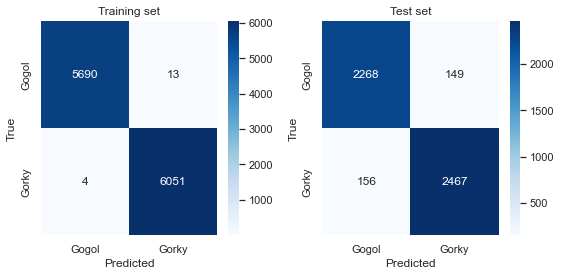

In [56]:
train_f1 = f1_score(y_train, model_svc.predict(X_train), average='macro', pos_label="Гоголь")
test_f1 = f1_score(y_test, model_svc.predict(X_test), average='macro', pos_label="Гоголь")
print(f"Training F1 score: {train_f1}")
print(f"Test F1 score: {test_f1}")

train_cm = confusion_matrix(y_train, model_svc.predict(X_train))
test_cm = confusion_matrix(y_test, model_svc.predict(X_test))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Gogol', 'Gorky'], yticklabels=['Gogol', 'Gorky'])
plt.title('Training set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1,2,2)
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Gogol', 'Gorky'], yticklabels=['Gogol', 'Gorky'])
plt.title('Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

**GridSearch SVC** для того, чтобы оптимизировать гиперпараметры модели.

In [58]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"F1 score: {grid_search.best_score_}")

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
F1 score: 0.9400703939921436


После подбора более оптимальных гиперпараметров получилось улучшить качество модели по метрике F1 score примерно на 0.004 **:D**

In [59]:
model_svc = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'], gamma=grid_search.best_params_['gamma'])
model_svc.fit(X_train, y_train)

SVC(C=10)

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'Гоголь') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'Гоголь') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Training F1 score: 1.0
Test F1 score: 0.9413805033399274


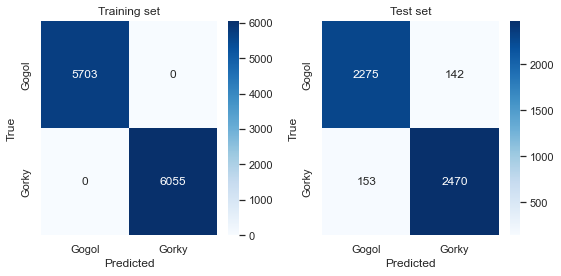

In [60]:
train_f1 = f1_score(y_train, model_svc.predict(X_train), average='macro', pos_label="Гоголь")
test_f1 = f1_score(y_test, model_svc.predict(X_test), average='macro', pos_label="Гоголь")
print(f"Training F1 score: {train_f1}")
print(f"Test F1 score: {test_f1}")

train_cm = confusion_matrix(y_train, model_svc.predict(X_train))
test_cm = confusion_matrix(y_test, model_svc.predict(X_test))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Gogol', 'Gorky'], yticklabels=['Gogol', 'Gorky'])
plt.title('Training set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1,2,2)
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Gogol', 'Gorky'], yticklabels=['Gogol', 'Gorky'])
plt.title('Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Не смотря на то, что с такими гиперпараметрами по метке Гоголь у нас F1_score = 1.0 на трейне, на тесте F1_score тоже очень высок(~0.94), что конечно вернее всего свидетельствует о переобучении модели, но может говорить и о том, что наш классификатор в рамках данного датасета действительно хорошо отличает предложения Горького, от предложений Гоголя. Можно было бы протестировать модель на каком-нибудь предложении которого нету в датасете, но для этого нужно было бы прикрутить пайплайн с векторайзером, а я не успеваю, тк модели долго учатся(особенно GridSearchCV, оооочень долго Т_Т)

#### 9. [1 балл] ROC AUC

Можно контролировать статистические ошибки первого и второго типов, используя различные пороговые значения для определения классов. Постройте ROC-кривые для логистической регрессии и SVC. Подберите такой порог, чтобы частота ложноположительных срабатываний составляла не более 30%. Обратите внимание на параметр `thresholds` в sklearn roc_curve.

In [61]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

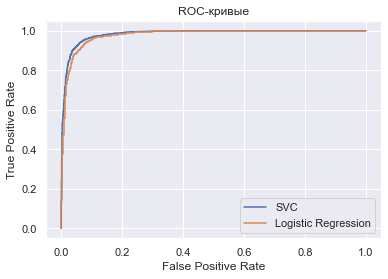

Порог для модели SVC: 0.048732508039455634


In [62]:
model_svc = SVC(probability=True)
model_svc.fit(X_train, y_train)

model_logit = LogisticRegression()
model_logit.fit(X_train, y_train)

y_prob_svc = model_svc.predict_proba(X_test)[:, 1]
y_prob_logit = model_logit.predict_proba(X_test)[:, 1]

# Преобразование меток в бинарный формат
le = LabelEncoder()
y_test_bin = le.fit_transform(y_test)

# Вычисление ROC-кривых
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_bin, y_prob_svc, pos_label=1)
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test_bin, y_prob_logit, pos_label=1)

# Поиск порога, соответствующего FPR <= 0.3
idx_svc = next(i for i, fpr in enumerate(fpr_svc) if fpr > 0.3)
threshold_svc = thresholds_svc[idx_svc]

# Построение ROC-кривых
plt.plot(fpr_svc, tpr_svc, label='SVC')
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend()
plt.show()

print('Порог для модели SVC:', threshold_svc)

### Многоклассовая классификация

#### 10. [1 балл] Примените <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a> из sklearn к реализованной логистической регресии для того, чтобы получить многоклассовый линейный классификатор:
* используйте набор данных, подготовленный в задании 7
* разделите данные на тренировочную и тестовую выборки, выделив под test 0.3 всех предложений (не забудьте зафиксировать random state)
* с помощью GridSearchCV найдите оптимальные гиперпараметры моделей (согласно метрике F1 score)
* постройте confusion matrix для train и test
* вычислите другие метрики качества для обученной модели (удобно воспользоваться реализацией из sklearn)
* проанализируйте полученные значения метрик, сделайте вывод о качестве обученной модели

GridSearch долго Т_Т

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier

In [64]:
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
class_counts = df['Автор'].value_counts()
print(class_counts)

Достоевский    22241
Толстой        16934
Горький         8678
Гоголь          8120
Брюсов          3684
Чехов           3219
Name: Автор, dtype: int64


In [65]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))
features = vectorizer.fit_transform(df["Предложение"])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(features, df["Автор"], test_size=0.3, random_state=42)

In [67]:
model = LogisticRegression(random_state=42)

In [69]:
modelOvO = OneVsOneClassifier(model)
modelOvO.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(random_state=42))

In [71]:
accuracy = modelOvO.score(X_test, y_test)
print(f'Точность классификации на тестовых данных: {accuracy:.2f}')

Точность классификации на тестовых данных: 0.78


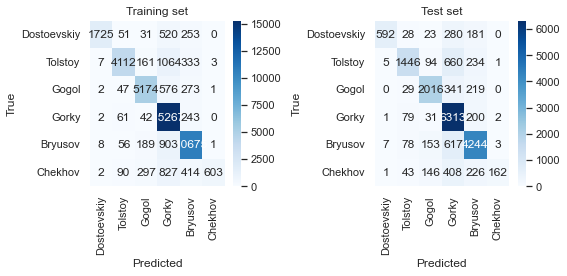

In [74]:
train_cm = confusion_matrix(y_train, modelOvO.predict(X_train))
test_cm = confusion_matrix(y_test, modelOvO.predict(X_test))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Dostoevskiy', 'Tolstoy', 'Gogol', 'Gorky', 'Bryusov', 'Chekhov'], yticklabels=['Dostoevskiy', 'Tolstoy', 'Gogol', 'Gorky', 'Bryusov', 'Chekhov'])
plt.title('Training set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1,2,2)
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Dostoevskiy', 'Tolstoy', 'Gogol', 'Gorky', 'Bryusov', 'Chekhov'], yticklabels=['Dostoevskiy', 'Tolstoy', 'Gogol', 'Gorky', 'Bryusov', 'Chekhov'])
plt.title('Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()